Zadanie 4 (1 pkt) <br>

Poczytaj o konwolucyjnych sieciach neuronowych np. tutaj: <br>
• https://towardsdatascience.com/a-beginners-guide-to-convolutional-neural-networks-cnns-14649dbddce8 <br>
• https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/ <br>

Przechodząc do praktyki, celem zadania jest wykorzystanie sieci konwolucyjnych do rozpoznawania psów i kotów z obrazków. <br>

Paczka ze zdjęciami (miniaturki) została dołączona na stronie (dogs-cats-mini.zip) <br>
i zwiera dokładnie 12500 zdjęć kotów i 12500 zdjęć psów (razem około 26 MB) <br>

Jaki jest plan działania: <br>
• Wybierz technologię / język programowania / tutorial. <br>
• Załaduj bazę danych. <br>
• Dokonaj jej obróbki (przetworzenie obrazów, wyciągnięcie klasy cat/dog z nazwy obrazka). <br>
• Podziel dane na zbiór testowy i treningowy (w losowy sposób), testowy może zawierać np. 20% danych. <br>
• Skonstruuj, wytrenuj model sieci konwolucyjnej na zbiorze treningowym. <br>
• Sprawdź jak dobrze poradziła sobie sieć (ewaluacja na zbiorze testowym). Wskaż obrazki, które sieć źle zaklasyfikowała.
<br>


Pomocne linki:

Python <br>
• https://www.kaggle.com/sarvajna/dogs-vs-cats-keras-solution <br>
• https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/ <br>
• https://towardsdatascience.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8
<br>

R-Studio <br>
• https://blogs.rstudio.com/tensorflow/posts/2017-12-14-image-classification-on-small-datasets/ <br>
• https://rpubs.com/kanedglsk/236125 <br>
• https://statist-bhfz.github.io/cats_dogs_finetune


### POSTĘPOWANIE WG TUTORIALU Sentdex'a: https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/

### NIE UŻYTO gotowych notebooków

### Dla przykładu wykorzystano pełną bazę kotów i psów (rozpakowane ~800MB) z zupełnie innego zadania (ominięcie podawania telefonu w Kaggle)
### https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/

### link mega.nz https://mega.nz/#!JWYmkaBZ!fb7D2LwZ3OB2bb9q0d-XuXDIDdNd7ExsKB0jmUuBv0c

In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

TRAIN_DIR = '/home/user/Pulpit/UG 2019 Magisterskie 1 rok/sztuczna madejski i jędrzejowicz/lab7/zad4_katalog/train/train'
TEST_DIR = '/home/user/Pulpit/UG 2019 Magisterskie 1 rok/sztuczna madejski i jędrzejowicz/lab7/zad4_katalog/test/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match



In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()

100%|██████████| 25000/25000 [00:42<00:00, 583.05it/s]


Najpierw zainstaluj specyficzną wersję tensorflow np.: (1.15) [wymagana dla biblioteki tflearn] <br>
dla tf 1.15 sypie ostrzeżeniami deprecated, natomiast działa <br>
dla tf 2.0 występuje błąd: "ModuleNotFoundError: No module named 'tensorflow.contrib'"

Następnie doinstalować w środowisku zależności: <br>
- Z GUI Anaconda: opencv, tqdm, matplotlib, numpy (później dla numpy dla załadowania danych allow_pickle=True) <br>

- Z shella: <br>
conda activate rstudio_env_second  <br> 
pip install tflearn <br>
- jeśli GUI za długo nie odpowiada: <br>
conda install --name rstudio_env_second matplotlib <br>
etc.

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')









Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

In [10]:
test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.19008 | time: 61.330s
| Adam | epoch: 003 | loss: 11.19008 - acc: 0.5140 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.25834 | time: 62.488s
| Adam | epoch: 003 | loss: 11.25834 - acc: 0.5111 | val_loss: 10.82215 - val_acc: 0.5300 -- iter: 24500/24500
--


#### ślepa uliczka - w 3 epokach nie poprawiła się dokładność

In [12]:
#reset instancji grafu
import tensorflow as tf
tf.reset_default_graph()

#### należy zwiększyć rozmiar konwolucji

In [13]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.51462 | time: 72.810s
| Adam | epoch: 003 | loss: 0.51462 - acc: 0.7323 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.51344 | time: 73.992s
| Adam | epoch: 003 | loss: 0.51344 - acc: 0.7341 | val_loss: 0.56104 - val_acc: 0.7260 -- iter: 24500/24500
--


#### zapisanie modelu dla przyszłego użycia

In [14]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/user/Pulpit/UG 2019 Magisterskie 1 rok/sztuczna madejski i jędrzejowicz/lab7/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


#### scenariusz wykorzystania poprzednio zapisanego modelu

In [15]:
#reset instancji grafu
import tensorflow as tf
tf.reset_default_graph()

In [16]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('/home/user/Pulpit/UG 2019 Magisterskie 1 rok/sztuczna madejski i jędrzejowicz/lab7/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 4978  | total loss: 0.30151 | time: 74.804s
| Adam | epoch: 010 | loss: 0.30151 - acc: 0.8694 -- iter: 24448/24500
Training Step: 4979  | total loss: 0.29782 | time: 76.066s
| Adam | epoch: 010 | loss: 0.29782 - acc: 0.8715 | val_loss: 0.57719 - val_acc: 0.7500 -- iter: 24500/24500
--
INFO:tensorflow:/home/user/Pulpit/UG 2019 Magisterskie 1 rok/sztuczna madejski i jędrzejowicz/lab7/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


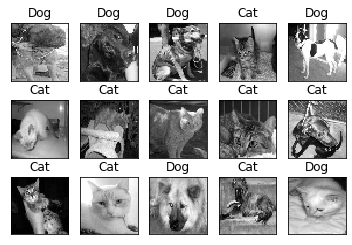

In [34]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy',  allow_pickle=True)

fig=plt.figure()

for num,data in enumerate(test_data[:15]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

obrazy w próbie zostały błędnie sklasyfikowane: <br>
nr <br>
10(pies sklasyfikowany jako kot), <br>
14(pies sklasyfikowany jako kot), <br>
15(kot sklasyfikowany jako pies)  